Bayesian GPLVM
--
This notebook shows how to use the Bayesian GPLVM model. GPLVM stands for Gaussian Process Latent Variable Model. It is an unsupervised learning method usually used for dimensionality reduction. For an in depth overview of GPLVMs please refer to *[1, 2]*.

In [15]:
import gpflow
from gpflow.util import training_loop
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Data

We are using the "three phase oil flow" data set used initially for demonstrating the Generative Topographic mapping from *[3]*.

In [16]:
data = np.load('./data/three_phase_oil_flow.npz')
Y = data['Y']  # following the GPflow notation we assume this dataset has size [num_data, output_dim]
labels = data['labels']  # integer in [0, 2] indicating to which class the datapoint belongs [num_data,]. Not used for model fitting, only for plotting afterwards.

print('Number of points: {} and Number of dimensions: {}'.format(Y.shape[0], Y.shape[1]))

Number of points: 100 and Number of dimensions: 12


### Model construction

We start by initialising the required variables

In [17]:
latent_dim = 2 # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0] # number of data points
X_mean_init = gpflow.models.gplvm.PCA_reduce(Y, latent_dim) # Initialise via PCA
X_var_init = np.ones((num_data, latent_dim))
Z_inducing_inputs_init = np.random.permutation(X_mean_init.copy())[:num_inducing] # Pick inducing inputs from dataset initialisation

We construct a RBF kernel operating on the two-dimensional latent space. 
The `ARD` parameters stands for 'Automatic Relevence Determination', which in practice means that
we learn a different lengthscale for each of the input dimensions, see [kernels](kernels).

In [18]:
kernel = gpflow.kernels.RBF(ard=True)

We have all the necesarry ingredients to construct the model. GPflow contains an implementation of the Bayesian GPLVM 

In [19]:
m = gpflow.models.gplvm.BayesianGPLVM(
    X_mean=X_mean_init,
    X_var=X_var_init,
    Y=Y,
    kernel=kernel,
    feature=Z_inducing_inputs_init
)

# we change the default likelihood variance, which is 1, to 0.01.
m.likelihood.variance = 0.01

Optimise the created model. Given that his model has a deterministic ELBO we can use Scipy's L-BFGS optimiser.

In [20]:
def closure():
    return m.neg_log_marginal_likelihood()

training_loop(closure, optimizer=tf.optimizers.Adam(), var_list=m.trainable_variables, maxiter=10000)

W0412 15:30:47.647732 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched expectation>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: KeyError during conversion: DEFINED_VARS_IN
W0412 15:30:47.718263 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched expectation>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: KeyError during conversion: DEFINED_VARS_IN
W0412 15:30:47.798667 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched expectation>> could not be transformed and will be staged without change. Error details can be found in the logs when running w

W0412 15:30:47.911683 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched Kuu>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: KeyError during conversion: DEFINED_VARS_IN


W0412 15:30:48.416593 140140513019712 deprecation.py:323] From /home/sergio.diaz/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:175: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
W0412 15:30:48.948943 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched expectation>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: KeyError during conversion: DEFINED_VARS_IN
W0412 15:30:49.019256 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched expectation>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the 

W0412 15:30:49.283093 140140513019712 tf_logging.py:161] Entity <bound method Dispatcher.__call__ of <dispatched Kuu>> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: KeyError during conversion: DEFINED_VARS_IN


### Analyse model
GPflow allows you to inspect the learned model hyper-parameters.

In [21]:
m

### Plotting vs PCA
The dimensionality reduction of the dataset to a two-dimesional space allows us to visualise the learned manifold.
We compare the Bayesian GPLVM's latent space to the deterministic PCA's one.

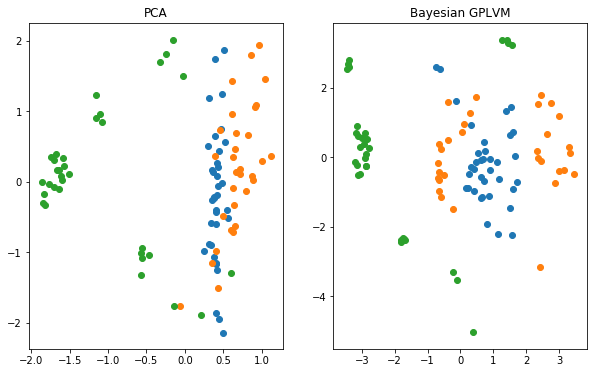

In [23]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
# when a model is trained we can access the values from the tensor as a `np.ndarray` using `read_value()`.
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1, 2, figsize=(10,6))

for i in np.unique(labels):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], label=i)
    ax[1].scatter(GPLVM_X_mean.numpy()[labels==i, 0], GPLVM_X_mean.numpy()[labels==i, 1], label=i)
    ax[0].set_title('PCA')
    ax[1].set_title('Bayesian GPLVM')
    

### References:
\[1\] Lawrence, Neil D. "Gaussian process latent variable models for visualisation of high dimensional data." Advances in neural information processing systems. 2004.

\[2\] Titsias, Michalis, and Neil D. Lawrence. "Bayesian Gaussian process latent variable model." Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics. 2010.

\[3\] Bishop, Christopher M., and Gwilym D. James. "Analysis of multiphase flows using dual-energy gamma densitometry and neural networks." Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 327.2-3 (1993): 580-593.